# Convolutional Neural Network using Sentinel 2 for the classification of landcover within South Dakota

This notebooknotebook sits alongside the masters thesis for Andrew Holden submitted as part of his stuidies towards a Masters in Geographical Information Management at Cranfield University. 


# Websites that have been useful 

Skydippers CNN code - building blocks which the rest of this has been built off - https://github.com/Skydipper/cnn-models

GEE - Sentinel 2 website - ([Sentinel 2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2)). 

Crop Data Later - ([Crop_Data_Layer](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL))

Useful for creating visualisations of the model and confusion matrix - https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras/notebook

ann-vis - very pretty visualisations of CNN - if you can get it working - https://github.com/Prodicode/ann-visualizer cant get ann_visualizer to install

Introduction to CNN in Keras - https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

Visualising CNN in Keras - includes confusion matrix - https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

Learning Rate Schedules and Adaptive Learning Rate Methods - https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

Visialise CNN - including showing the visualisation layers - https://www.codeastar.com/visualize-convolutional-neural-network/

Includes how to generate a flow chart of the model - https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/

Difference between a batch and and Epoch - https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

Simple intro to CNN - https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac

Advanced into to CNN... - https://towardsdatascience.com/advanced-topics-in-deep-convolutional-neural-networks-71ef1190522d

Interesting histograms and adding legends to charts - https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/classify-plot-raster-data-in-python/


## Configure the Environment

In [1]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image
from functools import reduce
import h5py
import seaborn as sns
from ee_datasets import ee_datasets
import seaborn as sns
import sklearn

Using TensorFlow backend.


In [2]:
# epochs
epc = 200
# land cover categories
cls = 8
#filter size
bth = 128
#number of bands 
bnd = 6
#chart titles
titles = ['Corn', 'Soy', 'Urban', 'Alfalfa','Other Hay','Water','Grass','Other']
titlesx=['Blue', 'Green', 'Red', 'NIR', 'NDVI', 'NDWI']
# Central position of (AOIs) - both containing a large amount of corn and soybean acres
points = [[-96.8389, 44.43378], [-97.580566, 43.678301]]

Initialize Earth Engine client

In [3]:
ee.Initialize()

**Functions**

In [4]:
def display_image(image, region, Vizz = None):
    """
    Displays images in notebook
    """ 
    ## Visualization
    if Vizz:
        image = image.visualize(**Vizz)
        
    visual = Image(url=image.getThumbUrl({
                'region':region
                }))
    
    display(visual)

In [5]:
def CloudMaskS2(image):
    """
    European Space Agency (ESA) clouds from 'QA60', i.e. Quality Assessment band at 60m
    parsed by Nick Clinton
    """
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)

    # Both flags set to zero indicates clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
            qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

In [6]:
def CloudFreeCompositeS2(Collection_id, startDate, stopDate, geom):
    ## Define your collection
    collection = ee.ImageCollection(Collection_id)

    ## Filter 
    collection = collection.filterBounds(geom).filterDate(startDate,stopDate)\
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
            .map(CloudMaskS2)

    ## Composite
    composite = collection.median()
    
    return composite

## Sentinel 2  
### Sentinel-2 MSI: MultiSpectral Instrument, Level-1C ([gee](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2))
**Dataset Availability**: 2015-06-23T00:00:00 - Present

**Wavebands**

|Band 	|Use 		|Wavelength (nm) |Resolution (m)|
|-------|-----------|----------------|--------------|
|B1 	|Aerosols 	|443 	|60|
|B2 	|Blue 		|490 	|10|
|B3 	|Green 		|560 	|10|
|B4 	|Red 		|665 	|10|
|B6 	|Red Edge 2 |740 	|20|
|B8 	|NIR        |835 	|10|
|B8a 	|Red Edge 4 |865 	|20|
|B9 	|Water vapor|940 	|60|
|B10 	|Cirrus 	|1375 	|60|
|B11 	|SWIR 1 	|1610 	|20|
|B12 	|SWIR 2 	|2190 	|20|
|QA60   |ESA Cloud  | n/a   |60|

In [7]:
# GEE Image Collection ID
Collection_id = 'COPERNICUS/S2'
# Start and stop of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')
# Scale in meters
scale = 10

## Set the Area of Interest 

In [8]:
# Area of Interest (AoI)
geom = ee.Geometry.Polygon([[[-104.04, 42.988], [-96.49, 42.98],[-96.49, 45.94],[-104.04, 45.94],[-104.04, 42.98]]], None, False)
region = geom.bounds().getInfo()['coordinates']

**Cloud Free Composites of the test sites**

RGB

In [9]:
# Visualization parameters
vis = {'min':0,'max':0.3, 'bands':['B4','B3','B2']}
# Cloud Free Composite
image = CloudFreeCompositeS2(Collection_id, startDate, stopDate, geom)
# Display Composite
display_image(image, region, Vizz = vis)

NIR

In [10]:
# Visualization parameters
vis = {'min':0,'max':0.5, 'gamma':1.5, 'bands':['B8']}
# Display Composite
display_image(image, region, Vizz = vis)

NDVI = (RED-NIR)/(RED+NIR)

In [11]:
# Visualization parameters
palette = ['blue', 'white', 'green']
vis = {'min': -0.8, 'max': 0.8, 'bands':'nd', 'palette': palette}
# Calculate NDVI
image_ndvi = image.normalizedDifference(['B8','B4'])
# Display NDVI
display_image(image_ndvi, region, Vizz = vis)

NDWI = (GREEN-NIR)/(GREEN+NIR)

In [12]:
# Visualization parameters
palette = ['blue', 'white', 'green']
vis = {'min': -0.8, 'max': 0.8, 'bands':'nd', 'palette': palette}
# Calculate NDWI
image_ndwi = image.normalizedDifference(['B8','B3'])
# Display NDWI
display_image(image_ndwi, region, Vizz = vis)

## Cropland Data Layer
### USDA NASS Cropland Data Layers ([gee](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL))

**Dataset Availability**: January 1997 - Present

**Resolution**
30 meters

**Bands**

|Name 	    |Min|Max |Description 	|
|-----------|---|----|--------------|
|cropland 	|1 	|254 |Main crop-specific land cover classification.|
|cultivated |1 	|2   |Classification layer for identifying cultivated and non-cultivated land cover. Available from 2013 to 2017.|
|confidence |0 	|100 |Per-pixel predicted confidence of the given classification, with 0 being the least confident and 100 the most confident.|

In [13]:
# GEE Image Collection ID
Collection_id = 'USDA/NASS/CDL'

In [14]:
Collection_id

'USDA/NASS/CDL'

Ground truth land cover classification

In [15]:
dataset = ee.ImageCollection(Collection_id)\
    .filterBounds(geom)\
    .filterDate(startDate,stopDate)

# First image
image = ee.Image(dataset.first())

# Choose the scale
image =  image.reproject(crs='EPSG:4326', scale=scale)

In [16]:
vis = {'min':1,'max':254, 'bands':'cropland'}
display_image(image, region, Vizz = vis)

## Download datasets
We download and stack datasets from two different Areas of Interest (AOIs)

In [17]:
#from ee_datasets import ee_datasets

for n, point in enumerate(points):
    sentinel = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
    cropland = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'CroplandDataLayers')
    dataset_x = sentinel.read_datasets()
    dataset_y = cropland.read_datasets()
    if n == 0:
        data_x = dataset_x
        data_y = dataset_y
    else:
        szy1, szx1 = data_x.shape[:2]
        szy2, szx2 = dataset_x.shape[:2]
        if szy1 != szy2 or szx1 != szx2:
            szy = min(szy1, szy2)
            szx = min(szx1, szx2)
            
            data_x = np.stack((data_x[:szy,:szx,:], dataset_x[:szy,:szx,:]), axis=0)
            data_y = np.stack((data_y[:szy,:szx,:], dataset_y[:szy,:szx,:]), axis=0)
        else:
            data_x = np.stack((data_x, dataset_x), axis=0)
            data_y = np.stack((data_y, dataset_y), axis=0)

**Display channels**

We display the input and output datasets

In [18]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

In [19]:
def display_channels_ax(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        plt.legend()
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

In [20]:
def display_channels_long(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(40,40))
        fig.subplots_adjust(hspace=0.5, wspace=0.5)
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

Sentinel 2 composite for the for the fist AOI

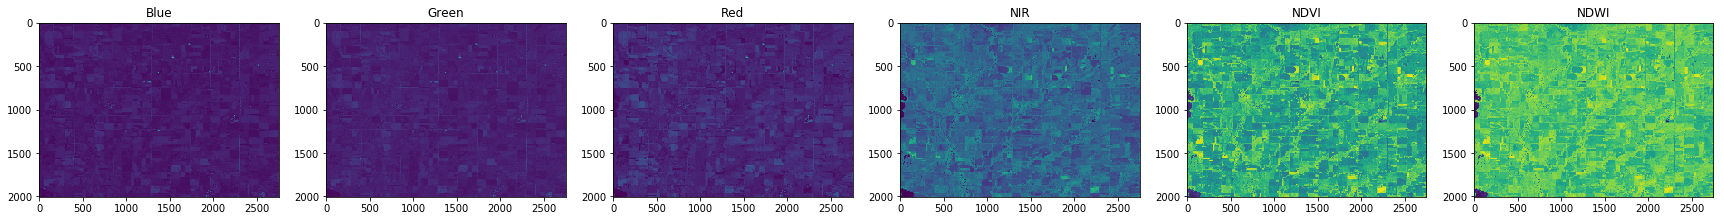

In [21]:
display_channels(data_x[0,:,:,:], data_x.shape[3], titles=titlesx)

Ground truth land cover classification for the for the fist AOI

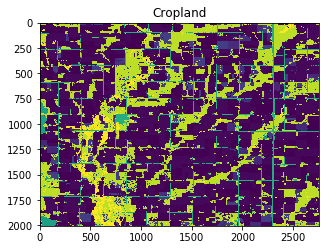

In [22]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles=['Cropland'])

Sentinel 2 composite for the for the second AOI

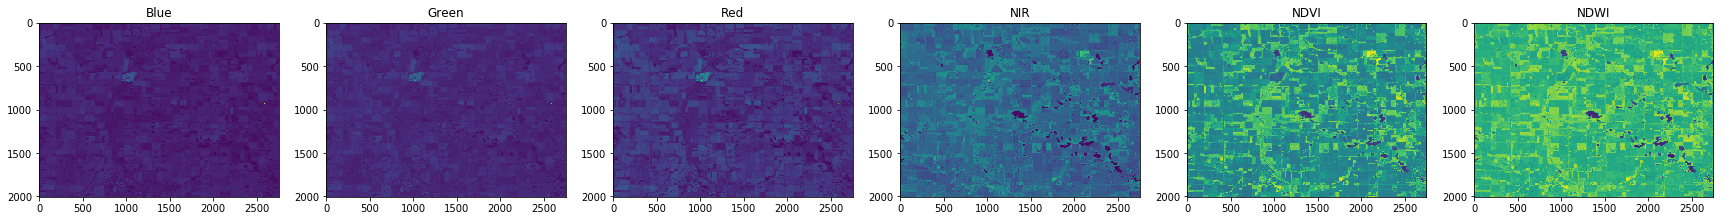

In [23]:
display_channels(data_x[1,:,:,:], data_x.shape[3], titles=titlesx)

Ground truth land cover classification for the for the second AOI

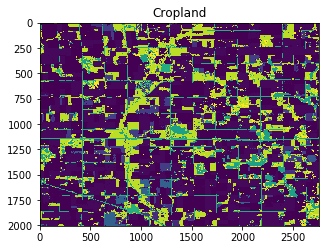

In [24]:
display_channels(data_y[1,:,:,:], data_y.shape[3], titles=['Cropland'])

## Preprocess class labels

Each class in encoded as a value in the range between 0 to 254. For training a Neural Network in Keras we have to convert the 1-dimensional class arrays to N classes-dimensional matrices. To simplify the problem here we regroup all the classes into 8 categories.

In [25]:
# Area of Interest (AoI)
geom = ee.Geometry.Point(points[0]).buffer(10000)
# Start and stop of time series
# startDate = ee.Date('2016')
# stopDate  = ee.Date('2017')
# Read the ImageCollection
dataset = ee.ImageCollection('USDA/NASS/CDL')\
    .filterBounds(geom)\
    .filterDate(startDate,stopDate)
# Get the cropland class values and names
cropland_info = pd.DataFrame({'cropland_class_values':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_values'),
                              'cropland_class_palette':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_palette'),
                              'cropland_class_names':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_names')
                             })
cropland_info.head()

,cropland_class_names,cropland_class_palette,cropland_class_values
0,Background,000000,0.0
1,Corn,ffd300,1.0
2,Cotton,ff2626,2.0
3,Rice,00a8e5,3.0
4,Sorghum,ff9e0c,4.0


The number of unique classes in this are is equal to:

In [26]:
len(np.unique(data_y[:,:,:,0]))

28

and the number of pixels by class

In [27]:
value, count = np.unique(data_y[0,:,:,0], return_counts=True)
df = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df = pd.merge(df, cropland_info, how='left', on=['cropland_class_values'])
df.head()

,cropland_class_counts,cropland_class_values,cropland_class_names,cropland_class_palette
0,1763951,1.0,Corn,ffd300
1,1603452,5.0,Soybeans,267000
2,1238444,176.0,Grassland/Pasture,e8ffbf
3,229862,121.0,Developed/Open Space,9b9b9b
4,164594,195.0,Herbaceous Wetlands,7fb2b2


In [28]:
value, count = np.unique(data_y[1,:,:,0], return_counts=True)
df = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df = pd.merge(df, cropland_info, how='left', on=['cropland_class_values'])
df.head()

,cropland_class_counts,cropland_class_values,cropland_class_names,cropland_class_palette
0,2013667,1.0,Corn,ffd300
1,1612165,5.0,Soybeans,267000
2,873435,176.0,Grassland/Pasture,e8ffbf
3,246536,121.0,Developed/Open Space,9b9b9b
4,229362,111.0,Open Water,4c70a3


In [29]:
# formula to change the class labels
def replace_values(array, class_labels, new_label):
    array_new = np.copy(array)
    for i in range(len(class_labels)):
        array_new[array == class_labels[i]] = new_label
        
    return array_new

## Reprocess the CDL categories into 8 classes

In [30]:
# New classes
corn = ['1']
soy = ['5']
urban = ['121', '122', '123', '124']
alf = ['36']
nonalf = ['37']
water = ['111']
grass = ['176']

#Concatenated list of classes
combined_classes = corn+soy+urban+alf+nonalf+water+grass

class_labels_1 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(corn)])
class_labels_2 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(soy)])
class_labels_3 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(urban)])
class_labels_4 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(alf)])
class_labels_5 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(nonalf)])
class_labels_6 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(water)]) 
class_labels_7 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(grass)]) 
class_labels_8 = np.array(cropland_info['cropland_class_values'][~cropland_info['cropland_class_values'].isin(combined_classes)])

# We replace the class labels - use 1000s to make sure values are not overwritten
new_data_y = np.copy(data_y[:,:,:,0])
new_data_y = replace_values(new_data_y, class_labels_1, 1000.)
new_data_y = replace_values(new_data_y, class_labels_2, 2000.)
new_data_y = replace_values(new_data_y, class_labels_3, 3000.)
new_data_y = replace_values(new_data_y, class_labels_4, 4000.)
new_data_y = replace_values(new_data_y, class_labels_5, 5000.)
new_data_y = replace_values(new_data_y, class_labels_6, 6000.)
new_data_y = replace_values(new_data_y, class_labels_7, 7000.)  
new_data_y = replace_values(new_data_y, class_labels_8, 8000.)

#Divide by 1000 and subtract 1 to get results 0 to 7
new_data_y = np.divide(new_data_y, 1000.) -1


# Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. 
# We reshape all data to 28x28x1 3D matrices.
# Keras requires an extra dimension in the end which correspond to channels. 
# MNIST images are gray scaled so it use only one channel. 
# For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.
# above taken from - https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

# Convert 1-dimensional class arrays to 4-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, cls)


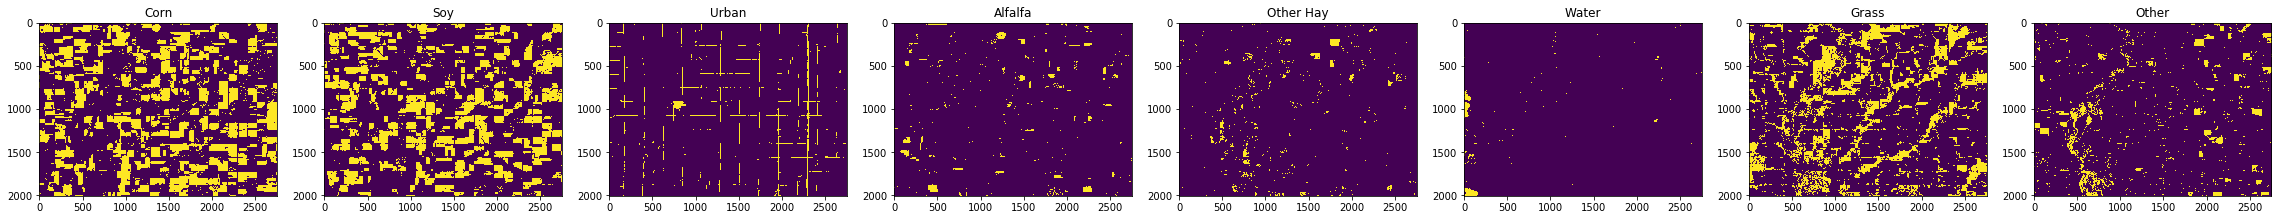

In [31]:
display_channels(new_data_y[0,:,:,:], new_data_y.shape[3], titles=titles)

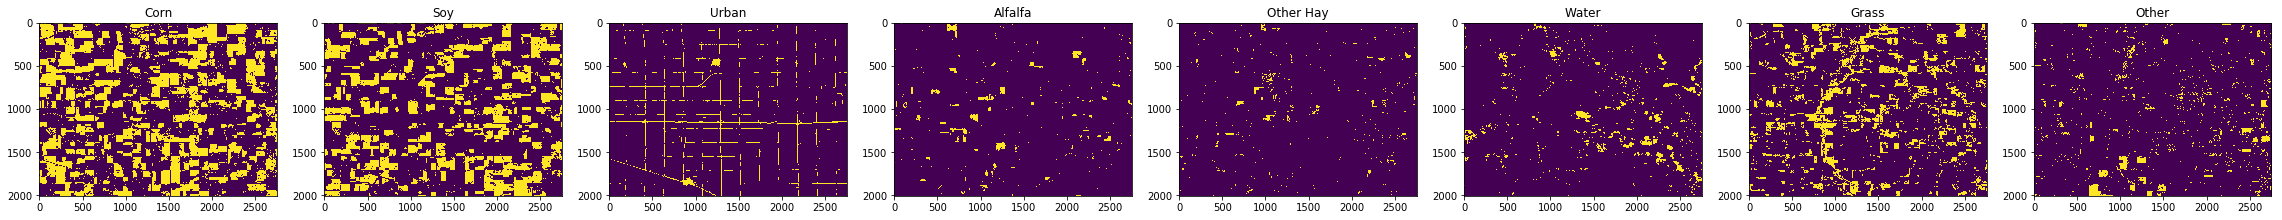

In [32]:
display_channels(new_data_y[1,:,:,:], new_data_y.shape[3], titles=titles)

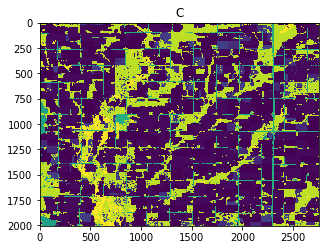

In [33]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles='Cropland')

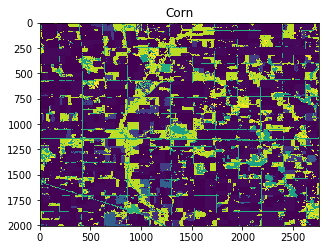

In [34]:
display_channels(data_y[1,:,:,:], data_y.shape[3], titles=titles)

In [35]:
#final piece of puts data_y to equal new data
data_y = new_data_y

New classification for the for the first AOI

### Checks on the shape and type of the datasets

In [36]:
#data_y size
np.size(data_y)

88272192

In [37]:
#shapre of data_y
np.shape(data_y)

(2, 2004, 2753, 8)

In [38]:
#number of dimensions in the data_y array
np.ndim(data_y)

4

### Interesting ways of presenting the data 
Need to transfer data_y into a pandas DF from numpy to get below 2 steps to work

In [39]:
# won't work as data needs to be reformatted into pandas
# data_y_df = pd.DataFrame({'Column1':data_y})

In [40]:
#also wont work as data in wrong format - put it in panda?
#sns.pairplot(data_y, hue='class')

In [41]:
#doesn't work on 4d matrix - run it when you have put 
#sns.countplot(data_y)

New classification for the for the second AOI

**Select input channels**

In [42]:
#don't need to do this when using 6 channels

# below is to run the data on the 3 channels
# data_x = data_x[:,:,:,3:]

In [43]:
data_x.shape

(2, 2004, 2753, 6)

## Preprocess datasets for training a Fully Connected Network (FCN)

**Normalize data**

In [44]:
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data.max()
        mn = data.min()
        
        data = (data-mn)/(mx-mn)
    return data

In [45]:
def normalize_data_backup(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data[:,:,:,i].max()
        mn = data[:,:,:,i].min()
        
        data[:,:,:,i] = (data[:,:,:,i]-mn)/(mx-mn)
    return data

In [46]:
data_x = normalize_data(data_x)

In [47]:
data_x.shape

(2, 2004, 2753, 6)

In [48]:
# plt.imshow(data_x)

**Resize the images**

In [49]:
# Current shape
data_x.shape

(2, 2004, 2753, 6)

In [50]:
data_y.shape

(2, 2004, 2753, 8)

In [51]:
def reshape_data(data):
    size = data.shape
    new_size = []
    new_size.append(reduce(lambda x, y: x*y, size[:-1]))
    new_size.append(size[-1])
    new_size = tuple(new_size)
    return size, new_size

In [52]:
size_x, new_size_x = reshape_data(data_x)
size_y, new_size_y = reshape_data(data_y)

data_x_new = data_x.reshape(new_size_x)
data_y_new = data_y.reshape(new_size_y)

Check on the new shape for x and y

In [53]:
data_x_new.shape

(11034024, 6)

In [54]:
data_y_new.shape

(11034024, 8)

**Randomize the datasets**

In [55]:
def randomize_datasets(data_x, data_y):
    t=data_x.shape[0]
    arr_t = np.arange(t)
    np.random.shuffle(arr_t)
    data_x = data_x[arr_t,:]
    data_y = data_y[arr_t,:]
    
    return data_x, data_y

In [56]:
x_randm, y_randm = randomize_datasets(data_x_new, data_y_new)

**Training and validation sets**

In [57]:
def train_validation_split(x, y, val_size=20):
    t=x.shape[0]
    size = int(t*((100-val_size)/100))
    
    xt = x[:size,:]
    xv = x[size:,:]
    yt = y[:size,:]
    yv = y[size:,:]
    
    return xt, xv, yt, yv

In [58]:
x_train, x_validation, y_train, y_validation = train_validation_split(x_randm, y_randm)

In [59]:
# Visualizing the number of different lables in training data 
#plt.figure(figsize=(8,4))
#sns.countplot(x='label', data=x_validation);

## Define the Keras model

Here we define a neural network with two hidden layers with `relu` nonlinearities.

In [60]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
#from keras.optimizers import RMSprop
#from keras.callbacks import Callback, ModelCheckpoint

# changed num_classes to howeveer many classes you set above
# set the number of epochs to 35 for full run, 1-3 for testing 
batch_size = bth
num_bands = bnd
num_classes = cls
epochs = epc

model = Sequential()

model.add(Dense(512, activation = 'relu', input_shape=(num_bands,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

W0814 03:54:32.753025 140682841802496 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 03:54:32.771653 140682841802496 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 03:54:32.774311 140682841802496 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 03:54:32.787368 140682841802496 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0814 03:54:32.795127 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               3584      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 4104      
Total params: 270,344
Trainable params: 270,344
Non-trainable params: 0
_________________________________________________________________


### Create a flow chart of the model - doesn't work yet

In [61]:
#create a plot of the model 
#model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, axis=1)

**Compile the model**

In [62]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

W0814 03:54:32.866356 140682841802496 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0814 03:54:32.873438 140682841802496 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



**Train the Neural Network**

In [63]:
from keras.callbacks import Callback, ModelCheckpoint

In [64]:
# To saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath="{0}_weights.hdf5".format('FCN'), verbose=1, save_best_only=True)

In [65]:
history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_validation, y_validation), callbacks=[checkpointer])

W0814 03:54:32.994555 140682841802496 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8827219 samples, validate on 2206805 samples
Epoch 1/200
8827219/8827219 [==============================] - 256s 29us/step - loss: 1.1112 - acc: 0.5972 - val_loss: 1.0733 - val_acc: 0.6080

Epoch 00001: val_loss improved from inf to 1.07334, saving model to FCN_weights.hdf5
Epoch 2/200
8827219/8827219 [==============================] - 254s 29us/step - loss: 1.1003 - acc: 0.6031 - val_loss: 1.1283 - val_acc: 0.5801

Epoch 00002: val_loss did not improve from 1.07334
Epoch 3/200
8827219/8827219 [==============================] - 254s 29us/step - loss: 1.1023 - acc: 0.6038 - val_loss: 1.0966 - val_acc: 0.6097

Epoch 00003: val_loss did not improve from 1.07334
Epoch 4/200
8827219/8827219 [==============================] - 252s 28us/step - loss: 1.1044 - acc: 0.6039 - val_loss: 1.0891 - val_acc: 0.6014

Epoch 00004: val_loss did not improve from 1.07334
Epoch 5/200
8827219/8827219 [==============================] - 254s 29us/step - loss: 1.1074 - acc: 0.6038 - val_loss: 1.1258 - 

8827219/8827219 [==============================] - 257s 29us/step - loss: 1.1368 - acc: 0.5971 - val_loss: 1.1156 - val_acc: 0.6050

Epoch 00042: val_loss did not improve from 1.07334
Epoch 43/200
8827219/8827219 [==============================] - 254s 29us/step - loss: 1.1375 - acc: 0.5970 - val_loss: 1.1188 - val_acc: 0.5969

Epoch 00043: val_loss did not improve from 1.07334
Epoch 44/200
8827219/8827219 [==============================] - 257s 29us/step - loss: 1.1381 - acc: 0.5965 - val_loss: 1.1105 - val_acc: 0.6025

Epoch 00044: val_loss did not improve from 1.07334
Epoch 45/200
8827219/8827219 [==============================] - 257s 29us/step - loss: 1.1392 - acc: 0.5965 - val_loss: 1.1121 - val_acc: 0.6009

Epoch 00045: val_loss did not improve from 1.07334
Epoch 46/200
8827219/8827219 [==============================] - 255s 29us/step - loss: 1.1392 - acc: 0.5966 - val_loss: 1.1170 - val_acc: 0.6053

Epoch 00046: val_loss did not improve from 1.07334
Epoch 47/200
8827219/8827219


Epoch 00083: val_loss did not improve from 1.07334
Epoch 84/200
8827219/8827219 [==============================] - 256s 29us/step - loss: 1.1690 - acc: 0.5900 - val_loss: 1.1329 - val_acc: 0.5997

Epoch 00084: val_loss did not improve from 1.07334
Epoch 85/200
8827219/8827219 [==============================] - 257s 29us/step - loss: 1.1692 - acc: 0.5893 - val_loss: 1.1561 - val_acc: 0.5554

Epoch 00085: val_loss did not improve from 1.07334
Epoch 86/200
8827219/8827219 [==============================] - 257s 29us/step - loss: 1.1695 - acc: 0.5894 - val_loss: 1.1790 - val_acc: 0.5908

Epoch 00086: val_loss did not improve from 1.07334
Epoch 87/200
8827219/8827219 [==============================] - 257s 29us/step - loss: 1.1689 - acc: 0.5894 - val_loss: 1.1466 - val_acc: 0.5998

Epoch 00087: val_loss did not improve from 1.07334
Epoch 88/200
8827219/8827219 [==============================] - 255s 29us/step - loss: 1.1708 - acc: 0.5892 - val_loss: 1.1230 - val_acc: 0.6035

Epoch 00088: v

8827219/8827219 [==============================] - 253s 29us/step - loss: 1.1966 - acc: 0.5801 - val_loss: 1.1684 - val_acc: 0.5708

Epoch 00125: val_loss did not improve from 1.07334
Epoch 126/200
8827219/8827219 [==============================] - 256s 29us/step - loss: 1.1967 - acc: 0.5795 - val_loss: 1.1464 - val_acc: 0.5908

Epoch 00126: val_loss did not improve from 1.07334
Epoch 127/200
8827219/8827219 [==============================] - 254s 29us/step - loss: 1.1957 - acc: 0.5796 - val_loss: 1.1361 - val_acc: 0.6020

Epoch 00127: val_loss did not improve from 1.07334
Epoch 128/200
8827219/8827219 [==============================] - 254s 29us/step - loss: 1.1957 - acc: 0.5795 - val_loss: 1.1828 - val_acc: 0.5625

Epoch 00128: val_loss did not improve from 1.07334
Epoch 129/200
8827219/8827219 [==============================] - 258s 29us/step - loss: 1.1955 - acc: 0.5795 - val_loss: 1.1757 - val_acc: 0.5726

Epoch 00129: val_loss did not improve from 1.07334
Epoch 130/200
8827219/88

8827219/8827219 [==============================] - 255s 29us/step - loss: 1.1903 - acc: 0.5801 - val_loss: 1.2422 - val_acc: 0.5284

Epoch 00166: val_loss did not improve from 1.07334
Epoch 167/200
8827219/8827219 [==============================] - 253s 29us/step - loss: 1.1911 - acc: 0.5802 - val_loss: 1.2767 - val_acc: 0.4951

Epoch 00167: val_loss did not improve from 1.07334
Epoch 168/200
8827219/8827219 [==============================] - 254s 29us/step - loss: 1.1916 - acc: 0.5802 - val_loss: 1.3233 - val_acc: 0.4457

Epoch 00168: val_loss did not improve from 1.07334
Epoch 169/200
8827219/8827219 [==============================] - 253s 29us/step - loss: 1.1910 - acc: 0.5804 - val_loss: 1.2507 - val_acc: 0.5246

Epoch 00169: val_loss did not improve from 1.07334
Epoch 170/200
8827219/8827219 [==============================] - 254s 29us/step - loss: 1.1917 - acc: 0.5804 - val_loss: 1.2900 - val_acc: 0.4670

Epoch 00170: val_loss did not improve from 1.07334
Epoch 171/200
8827219/88

**Evaluate model**

In [66]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.302400983710049
Test accuracy: 0.48654004318467153


Visualising the keras model 

In [67]:
# # taken from https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras
# from keras.models import Model
# layer_outputs = [layer.output for layer in model.layers]
# activation_model = Model(inputs=model.input, outputs=layer_outputs)
# activations = activation_model.predict(x_train[10])

# #.reshape(1,28,28,1

# def display_activation(activations, col_size, row_size, act_index): 
#     activation = activations[act_index]
#     activation_index=0
#     fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
#     for row in range(0,row_size):
#         for col in range(0,col_size):
#             ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
#             activation_index += 1

### More visualisation parameters

Would be useful if you could get these working 

In [68]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [69]:
# # data visualisation
# # https://towardsdatascience.com/visualizing-artificial-neural-networks-anns-with-just-one-line-of-code-b4233607209e
# from ann_visualizer.visualize import ann_viz;
# ann_viz(model, title="Neural Network Visualisation")

# #display the second layer in an 8x8 grid (8,8,1)
# display_activation(activations, 8, 8, 1)

# Model analysis Graphs

In [70]:
# model.freeze_to(-1)
# model.lr_find()
# model.recorder.plot()

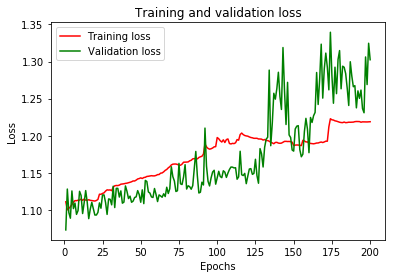

In [71]:
#Plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

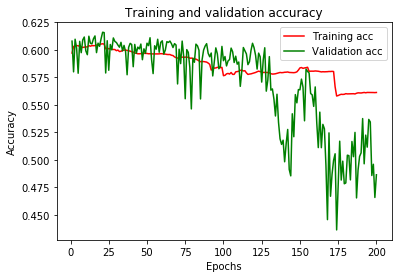

In [72]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix

In [73]:
# taken from https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras
from sklearn.metrics import confusion_matrix
Y_prediction = model.predict(x_validation)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validation,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

[Text(51.0, 0.5, 'Actual'), Text(0.5, 51.0, 'Predicted')]

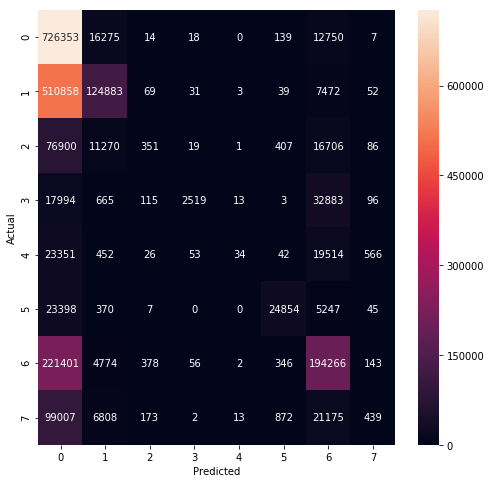

In [74]:
#plot the matrix
plt.figure(figsize=(cls,cls))
confuse = sns.heatmap(confusion_mtx, annot=True, fmt="d");
confuse.set(xlabel='Predicted', ylabel='Actual')

**Read the weights**

In [75]:
#changed the num_classes from 4 to 6
batch_size = bth
num_bands = bnd
num_classes = cls
epochs = epc

model = Sequential()
model = Sequential()

model.add(Dense(512, activation = 'relu', input_shape=(num_bands,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

model.load_weights("{0}_weights.hdf5".format('FCN'))

## Predict on the test region

Test the FCN on the central region of South Dakota

In [76]:
# Central position of (AOIs) - Dell Rapids - South Dakota
point = [-96.61651, 43.933506]

In [77]:
# buffer set to 10k - usually set to 10k - much larger area used
sentinel = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
dataset_x = sentinel.read_datasets()
cropland = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'CroplandDataLayers')
dataset_y = cropland.read_datasets()

We select the NIR, NDVI, NDWI channels

In [78]:
#below edited from data_x = dataset_x[:,:,3:]
data_x = dataset_x
data_y = dataset_y

Sentinel 2 composite

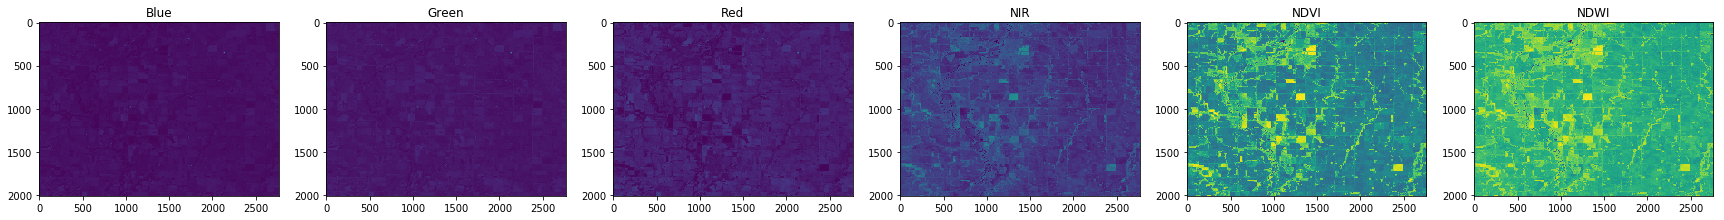

In [79]:
display_channels(data_x, data_x.shape[2], titles=titlesx)

Ground truth land cover classification

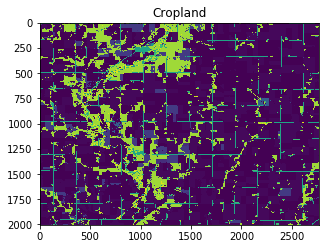

In [80]:
display_channels(data_y, data_y.shape[2], titles=['Cropland'])

**Preprocess class labels**

In [81]:
data_y.shape

(2004, 2765, 1)

In [82]:
# replacing class labels again - now we have a 3D array so had to remove :, from the data_y 
new_data_y = np.copy(data_y[:,:,0])
new_data_y = replace_values(new_data_y, class_labels_1, 1000.)
new_data_y = replace_values(new_data_y, class_labels_2, 2000.)
new_data_y = replace_values(new_data_y, class_labels_3, 3000.)
new_data_y = replace_values(new_data_y, class_labels_4, 4000.)
new_data_y = replace_values(new_data_y, class_labels_5, 5000.)
new_data_y = replace_values(new_data_y, class_labels_6, 6000.)
new_data_y = replace_values(new_data_y, class_labels_7, 7000.)  
new_data_y = replace_values(new_data_y, class_labels_8, 8000.)

#Divide by 1000 and subtract 1 to get results 0 to 7
new_data_y = np.divide(new_data_y, 1000.) -1
# Convert 1-dimensional class arrays to 4-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, cls)

Output classes

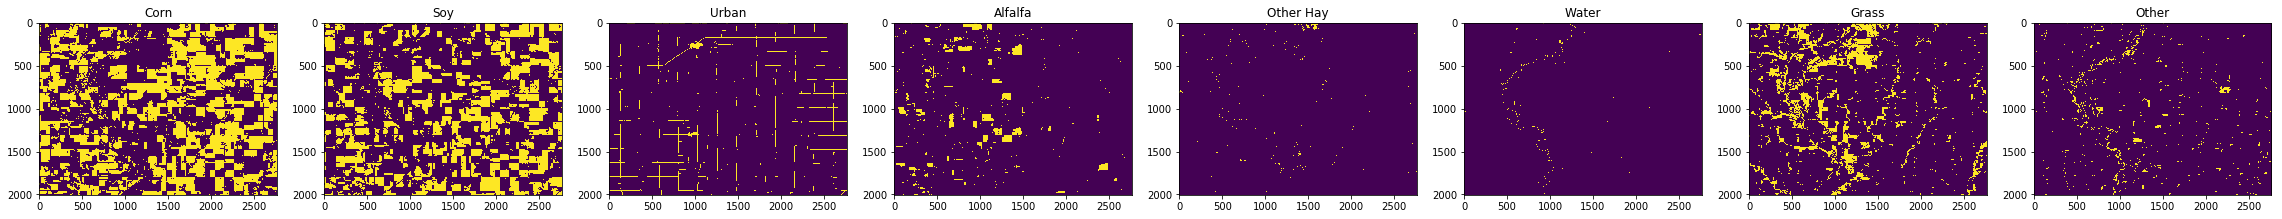

In [83]:
display_channels(new_data_y, new_data_y.shape[2], titles=titles)

**Preprocess input dataset**

In [84]:
# Normalize
# Backup


# def normalize_data(data):
#     size = data.shape
#     for i in range(size[-1]):
#         mx = data[:,:,i].max()
#         mn = data[:,:,i].min()
        
#         data[:,:,i] = (data[:,:,i]-mn)/(mx-mn)
#     return data
# data_x_norm = normalize_data(data_x)

In [85]:
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data.max()
        mn = data.min()
        
        data = (data-mn)/(mx-mn)
    return data

In [86]:
# Normalize
data_x_norm = normalize_data(data_x)
# Resize
size_x, new_size_x = reshape_data(data_x_norm)

x_input = data_x_norm.reshape(new_size_x)

**Compute the prediction**

In [87]:
y_output = model.predict(x_input, batch_size=batch_size, verbose=0)

**Resize the output**

In [88]:
data_y_output = y_output.reshape((size_x[0], size_x[1],cls))

**Display the output**

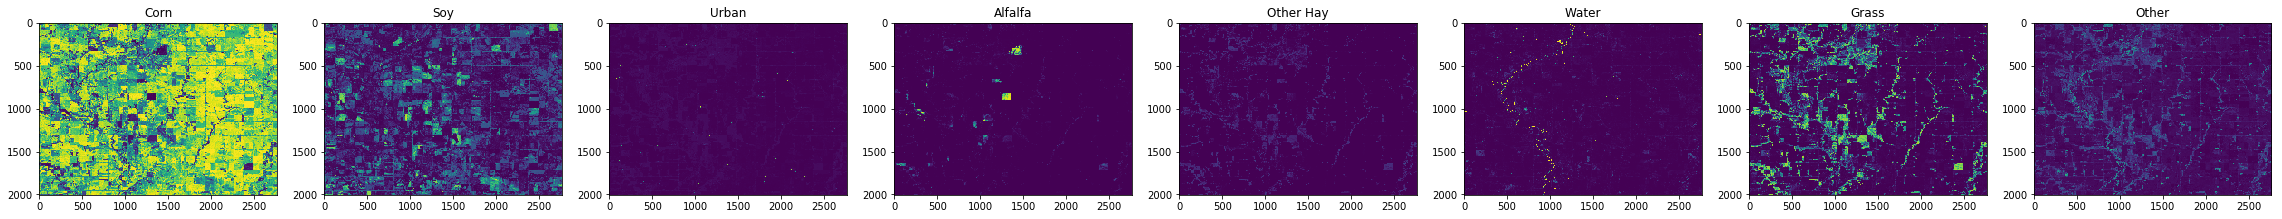

In [89]:
display_channels(data_y_output, data_y_output.shape[2], titles=titles)

We binarize the output taking the highest pixel value

In [90]:
# Binarize the output
def max_pixels(x):
    x_new = x*0
    max_val = np.amax(x, axis=2)
    size = x.shape
    for i in range(size[-1]):
        ima = x[:,:,i]*0
        ima[np.where(x[:,:,i] == max_val)] = 1
        x_new[:,:,i]= ima

    return x_new

In [91]:
data_y_output_max = max_pixels(data_y_output)

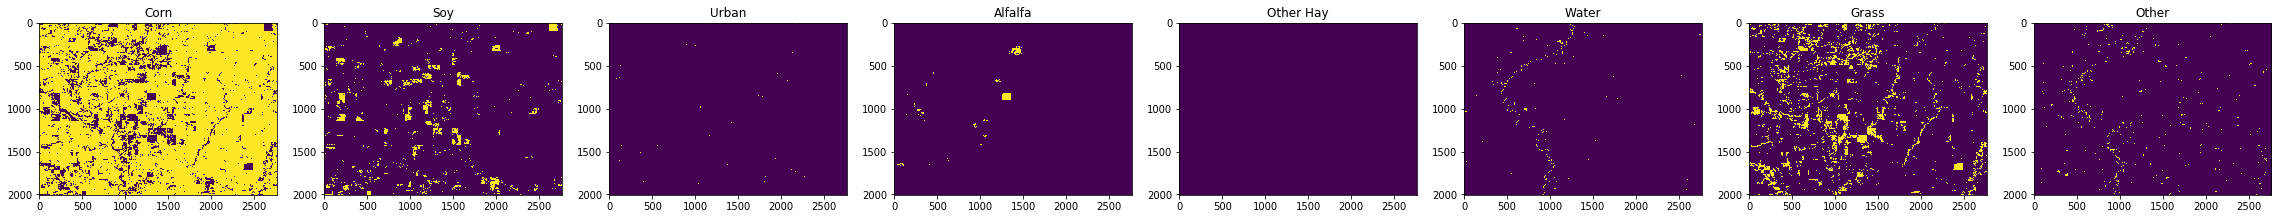

In [92]:
display_channels(data_y_output_max, data_y_output.shape[2], titles=titles)